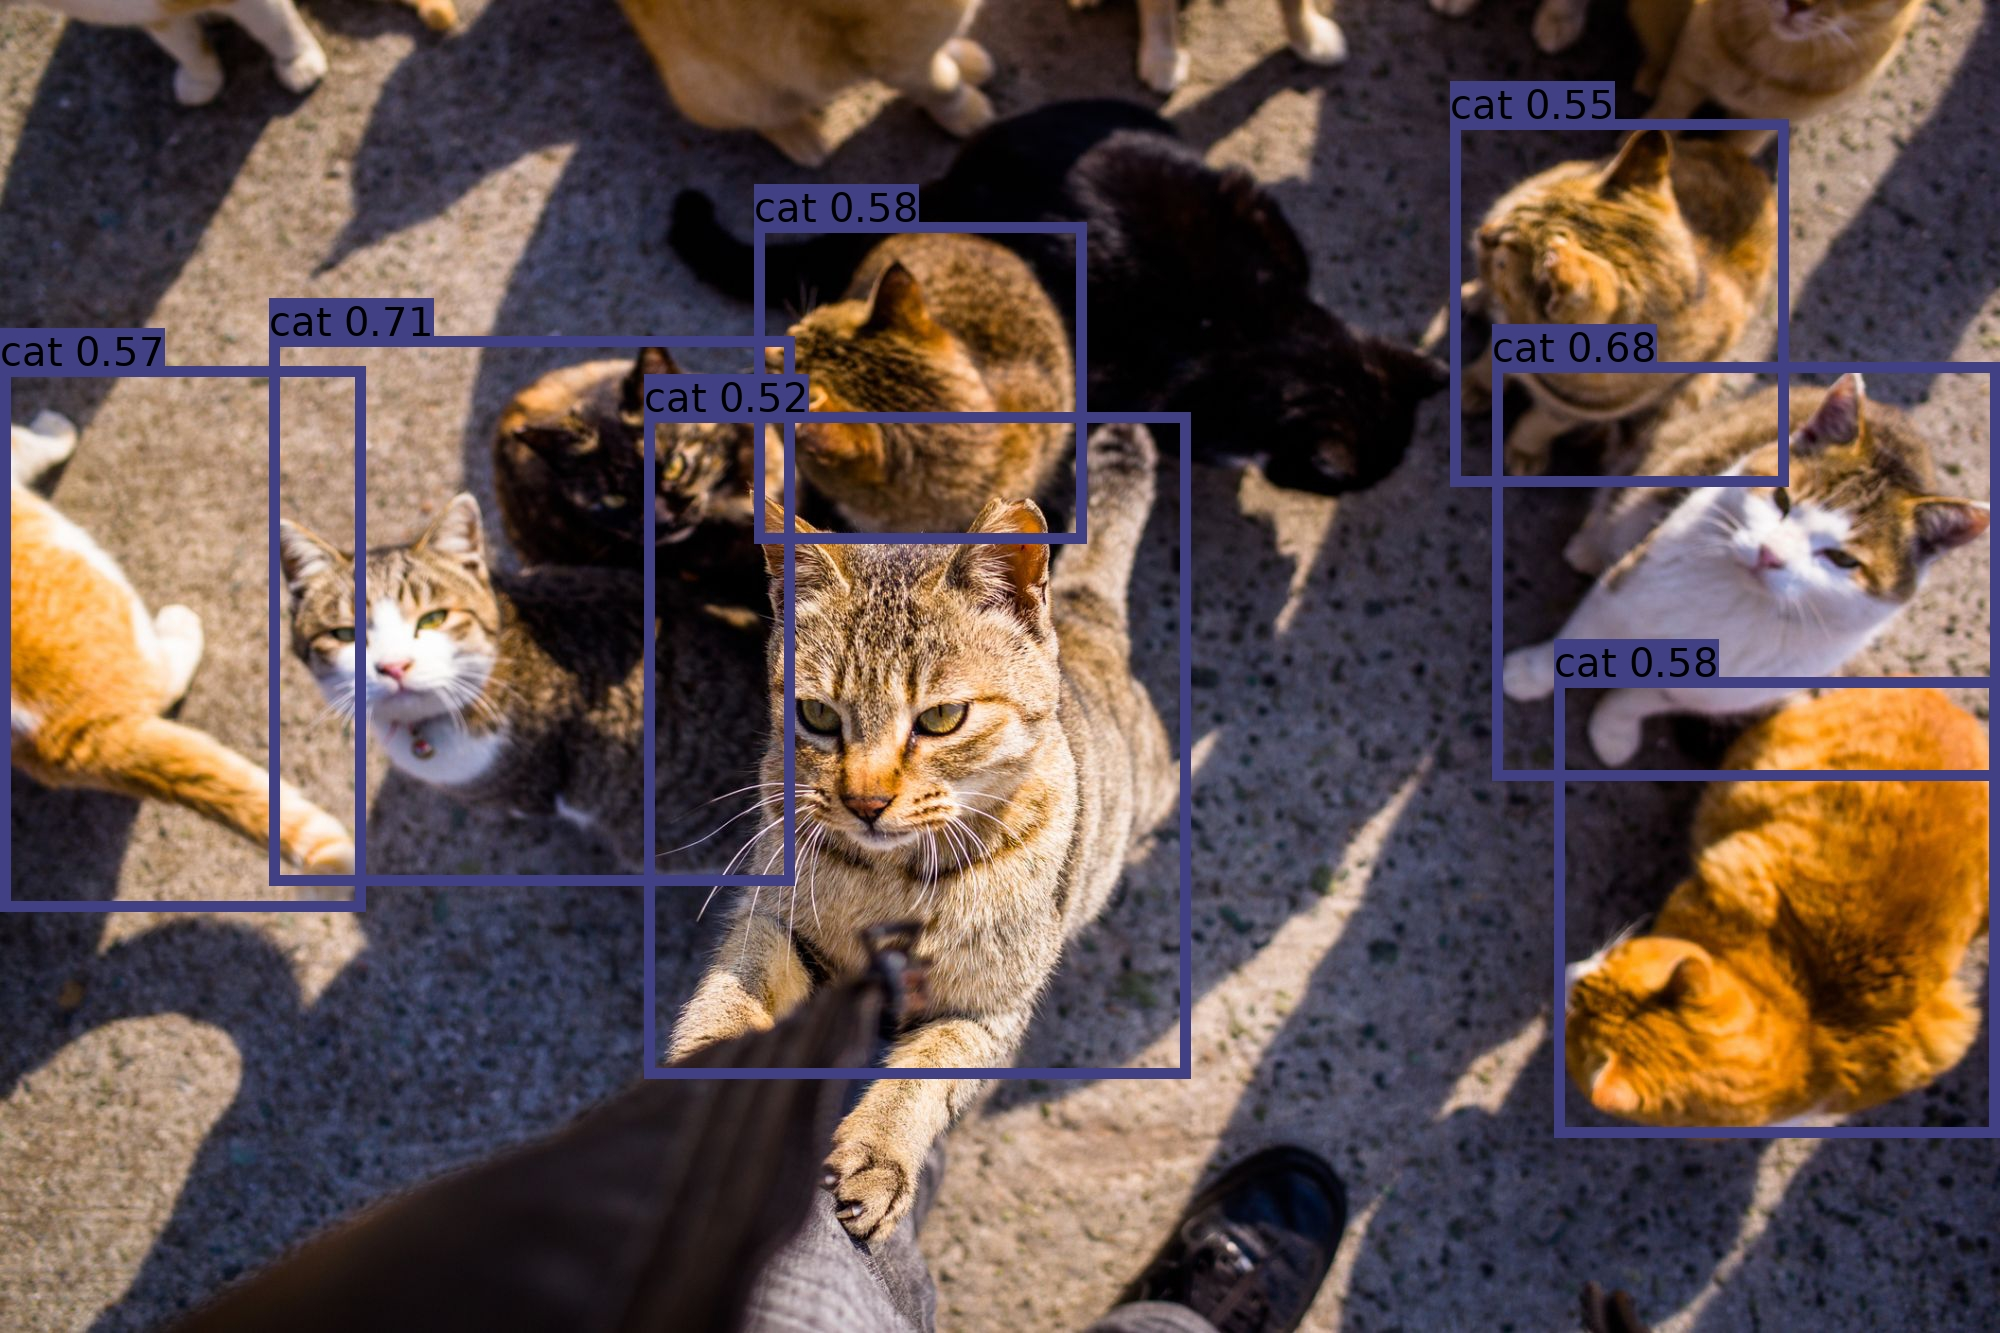

# Notebook d'inference

Ce notebook qui contient un script d'inférence est à transformer en webapp pour effectuer des prédictions.

## Get an image

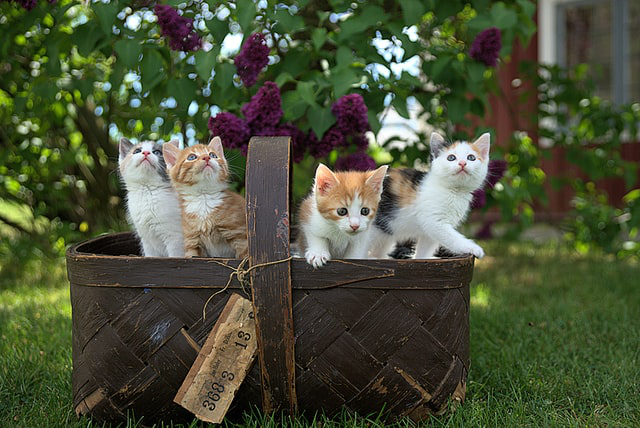

In [1]:
import base64
from io import BytesIO

import requests
from PIL import Image

response = requests.get("https://unsplash.com/photos/YCPkW_r_6uA/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjU1NTU3ODcz&force=true&w=640")
img = Image.open(BytesIO(response.content))
if img.mode == "RGBA":
    img = img.convert("RGB")

img

In [2]:
# Transform the image to base64 string

buffer = BytesIO()
img.save(buffer, format="JPEG")
img_str: str = base64.b64encode(buffer.getvalue()).decode("utf-8")

## Set server URL

In [3]:
#@title Set server URL
server_url = "https://wide-parks-rest-35-230-172-249.loca.lt" #@param {type:"string"}

## Select model

In [4]:
yolo_model = "yolov5m" #@param ["yolov5s", "yolov5m", "yolov5l", "yolov5x"] {allow-input: true}


## Perform the inference

In [5]:
r = requests.post(f"{server_url}/predict", json={"model": yolo_model, "image": img_str})
if r.status_code == 200:
    result = r.json()
else:
    print(r.status_code)

In [6]:
# Let's get a list of all detected classes
classes = list(set(map(lambda x: x['class_name'], result['detections'])))

In [7]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from PIL import  ImageDraw, ImageFont


def draw_preds(image, preds, class_names):

    image = image.copy()

    colors = plt.cm.get_cmap("viridis", len(class_names)).colors
    colors = (colors[:, :3] * 255.0).astype(np.uint8)

    font = list(Path("/usr/share/fonts").glob("**/*.ttf"))[0].name
    font = ImageFont.truetype(font=font, size=np.floor(3e-2 * image.size[1] + 0.5).astype("int32"))
    thickness = (image.size[0] + image.size[1]) // 300

    for pred in preds:
        score = pred['confidence']
        predicted_class = pred['class_name']

        label = "{} {:.2f}".format(predicted_class, score)

        draw = ImageDraw.Draw(image)
        label_size = draw.textsize(label, font)

        top = pred['y_min']
        left = pred['x_min']
        bottom = pred['y_max']
        right = pred['x_max']
        print(label, (left, top), (right, bottom))

        if top - label_size[1] >= 0:
            text_origin = np.array([left, top - label_size[1]])
        else:
            text_origin = np.array([left, top + 1])

        # My kingdom for a good redistributable image drawing library.
        for r in range(thickness):
            draw.rectangle([left + r, top + r, right - r, bottom - r], outline=tuple(colors[class_names.index(predicted_class)]))
        draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=tuple(colors[class_names.index(predicted_class)]))
        draw.text(text_origin, label, fill=(0, 0, 0), font=font)
        del draw

    return image

In [8]:
image_with_preds = draw_preds(img, result['detections'], classes)

cat 0.72 (162, 136) (248, 259)
cat 0.71 (117, 136) (185, 258)
cat 0.55 (297, 130) (496, 266)
cat 0.40 (295, 161) (393, 269)
bench 0.37 (66, 142) (480, 423)


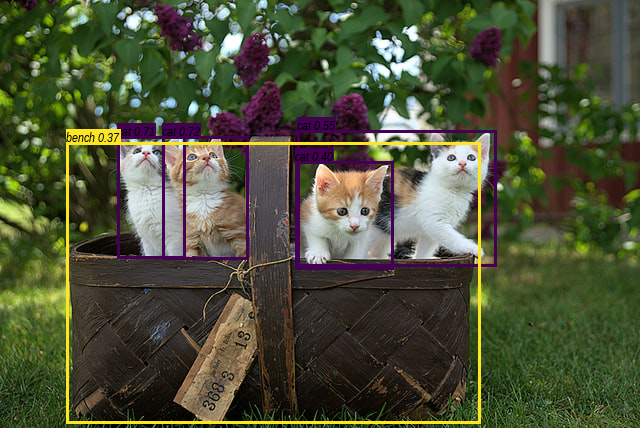

In [9]:
from IPython.display import display  # to display images

display(image_with_preds)